In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json
import torch
import time
import numpy as np
import random
import torch.nn.functional as F
from transformers import DynamicCache, SlidingWindowCache
from trimkv.models.qwen3 import TrimKVQwen3ForCausalLM, TrimKVQwen3Config
from trimkv.cache_utils import TrimKVCache
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from transformers import Qwen3ForCausalLM
from datasets import load_dataset

# set print options
torch.set_printoptions(precision=4, sci_mode=False, linewidth=120)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

/gpfs/radev/pi/ying_rex/nhb25/.conda/envs/kvm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_path = "ngocbh/TrimKV-Qwen3-4B-Math"
download_from = "huggingface" # there options: wandb, local, huggingface

model = TrimKVQwen3ForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    load_trimkv_weights=True,
    download_from=download_from,
    use_cache=True,
    device_map="cuda",
)
model.config._attn_implementation = 'flash_attention_2'
model.config.compress_memory = True
model.config.memory_size = 256
model.config.buffer_size = 32

tokenizer = AutoTokenizer.from_pretrained(
    model.config.base_model, use_fast=True, padding_side="left"
)

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 37532.92it/s]
`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


Downloaded model from HuggingFace to: /gpfs/radev/scratch/ying_rex/nhb25/.cache/huggingface/hub/models--ngocbh--TrimKV-Qwen3-4B-Math/snapshots/182f1e3967b437e8e0dae4cb48851a6c7b7d420b


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
Some weights of TrimKVQwen3ForCausalLM were not initialized from the model checkpoint at Qwen/Qwen3-4B and are newly initialized: ['model.layers.0.self_attn.retention_gate.bias', 'model.layers.0.self_attn.retention_gate.linear1.bias', 'model.layers.0.self_attn.retention_gate.linear1.weight', 'model.layers.0.self_attn.retention_gate.linear2.weight', 'model.layers.1.self_attn.retention_gate.bias', 'model.layers.1.self_attn.retention_gate.linear1.bias', 'model.layers.1.self_attn.retention_gate.linear1.weight', 'model.layers.1.self_attn.retention_gate.linear2.weight', 'model.layers.10.self_attn.retention_gate.bias', 'model.layers.10.self_attn.retention_gate.linear1.bias', 'model.layers.10.self_attn.retention_gate.linear1.weight', 'model.layers.10.self_attn.retention_gate.linear2.weight', 'model.layers.11.self_attn.retention_gate.bias', 'model.layers.11.self_attn.retention_gate.linear1.bias', 'model.layers.11.self_attn

Retention gate weights loaded successfully.


In [4]:

@torch.inference_mode()
def generate(
    model,
    tokenizer,
    prompts,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 1.0,
    do_sample: bool = True,
    eos_token_id: int | None = None,
    device: str | torch.device | None = None,
):
    dev = device or model.device
    model.eval()

    model_inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=tokenizer.model_max_length,
    ).to(dev)

    end_token_ids = (
        [tokenizer.eos_token_id]
        + [model.config.eos_token_id]
    )

    if isinstance(model, Qwen3ForCausalLM):
        pkv = DynamicCache()
    else:
        pkv = TrimKVCache()

    input_ids = model_inputs.input_ids
    attention_mask = model_inputs.attention_mask

    # start_time = torch.cuda.Event(enable_timing=True)
    # end_time = torch.cuda.Event(enable_timing=True)
    # start_time.record()
    # forward pass to get past_key_values
    out = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        past_key_values=pkv,
        use_cache=True
    )
    next_token_logits = out.logits[:, -1, :]          # (B, V)
    # end_time.record()
    # torch.cuda.synchronize()  # Wait for the events to be recorded
    # elapsed_time = start_time.elapsed_time(end_time)  # Time in milliseconds
    # print(f"Initial forward pass time: {elapsed_time:.2f} ms")

    # store per-sequence token lists
    generated = model_inputs.input_ids.tolist()       # List[List[int]]
    finished = [False] * len(prompts)                 # early-stop flags
    logs = [
        pkv.log()
    ]

    for idx in range(max_new_tokens):
        if temperature != 1.0:
            next_token_logits = next_token_logits / temperature

        probs = F.softmax(next_token_logits, dim=-1)

        if do_sample and top_p < 1.0:
            sorted_probs, sorted_idx = torch.sort(probs, dim=-1, descending=True)
            cumprobs = torch.cumsum(sorted_probs, dim=-1)
            mask = cumprobs > top_p
            sorted_probs = sorted_probs.masked_fill(mask, 0.0)
            probs = torch.zeros_like(probs).scatter_(1, sorted_idx, sorted_probs)
            probs = probs / probs.sum(dim=-1, keepdim=True)

        # sample / greedy
        next_token = (
            torch.multinomial(probs, num_samples=1) if do_sample
            else probs.argmax(dim=-1, keepdim=True)
        )                                             # (B, 1)
        # print(next_token, tokenizer.batch_decode(next_token, skip_special_tokens=True))
        # print(idx, tokenizer.batch_decode(next_token, skip_special_tokens=True)[0], end='\n', flush=True)
        print(tokenizer.batch_decode(next_token, skip_special_tokens=True)[0], end='', flush=True)

        # append and check EOS per sequence
        for i, tok in enumerate(next_token.squeeze(1).tolist()):
            if not finished[i]:
                generated[i].append(tok)
            if tok in end_token_ids:
                    finished[i] = True
        if all(finished):
            break

        attention_mask = torch.cat(
            [
                attention_mask,
                torch.ones((len(prompts), 1), dtype=torch.long, device=dev),
            ],
            dim=-1,
        )

        # start_time.record()
        # feed only the freshly generated tokens
        next_token_logits = model(
            input_ids=next_token,
            attention_mask=attention_mask,
            past_key_values=pkv,
            use_cache=True,
        ).logits[:, -1, :]                            # (B, V)

        logs.append(pkv.log())
        # end_time.record()
        # torch.cuda.synchronize()  # Wait for the events to be recorded
        # elapsed_time = start_time.elapsed_time(end_time)  # Time in milliseconds
        # print(f"Forward pass time for token generation: {elapsed_time:.2f} ms", _)

    # remove the input_ids from the generated sequences
    texts = []
    print("\n")

    for i, seq in enumerate(generated):
        # seq = seq[len(model_inputs.input_ids[i]):]
        print(f"Len of generated sequence {i}: {len(seq)}")
        texts.append({
            "raw_token_ids": seq,
            "text": tokenizer.decode(seq, skip_special_tokens=False)
        })
    return texts, pkv, logs


In [5]:
model.config.compress_memory = True
model.config.compress_strategy = "alpha"
model.config.memory_size = 256

prompts = [
    "<|im_start|>user\nYou are given a math problem.\n\nProblem: Every morning Aya goes for a $9$-kilometer-long walk and stops at a coffee shop afterwards. When she walks at a constant speed of $s$ kilometers per hour, the walk takes her 4 hours, including $t$ minutes spent in the coffee shop. When she walks $s+2$ kilometers per hour, the walk takes her 2 hours and 24 minutes, including $t$ minutes spent in the coffee shop. Suppose Aya walks at $s+\\frac{1}{2}$ kilometers per hour. Find the number of minutes the walk takes her, including the $t$ minutes spent in the coffee shop.\n\n You need to solve the problem step by step. First, you need to provide the chain-of-thought, then provide the final answer.\n\n Provide the final answer in the format: Final answer:  \\boxed{}<|im_end|>\n<|im_start|>assistant\n"
]

text, pkv, logs = generate(model, tokenizer,
                prompts=prompts,
                max_new_tokens=16000,
                temperature=0.7,
                do_sample=False,
                top_p=0.9)

<think>
Okay, let's try to solve this problem. So, Aya walks 9 kilometers every morning, stops at a coffee shop, and we need to find out how long her walk takes when she walks at a speed of s + 1/2 km/h, including the time she spends in the coffee shop. 

First, let me parse the problem again. There are two scenarios given. In the first scenario, when she walks at a constant speed of s km/h, the total time for the walk (including time in the coffee shop) is 4 hours. In the second scenario, when she walks at s + 2 km/h, the total time is 2 hours and 24 minutes, which is the same t minutes spent in the coffee shop. So, the time spent in the coffee shop is the same in both cases, which is t minutes. 

So, the key here is that the time spent in the coffee shop is the same in both scenarios. Therefore, the difference in the total time between the two scenarios must be due to the difference in the walking time. 

Let me write down the equations. 

First, when she walks at speed s km/h, the t

In [6]:

def get_eviction_matrix(logs, layer_idx, head_idx, seq_len):
    evic_mat = torch.zeros((seq_len, seq_len), dtype=torch.float32).cpu()
    prefill_len = logs[0][layer_idx]['seen_tokens']
    # triangular matrix of prefill length is set to 1.0
    i, j = torch.tril_indices(prefill_len, prefill_len, offset=0, device=evic_mat.device)
    evic_mat[:prefill_len, :prefill_len][i, j] = 1.0

    for log in logs:
        layer_log = log[layer_idx]
        seen_tokens = layer_log['seen_tokens']
        kv_positions = layer_log['kv_positions'][0, head_idx].cpu()
        evic_mat[seen_tokens, kv_positions] = 1.0
        evic_mat[seen_tokens, seen_tokens] = 1.0
    return evic_mat

layer_idx = 0
head_idx = 0
seq_len = pkv.get_seq_length() + 1
evic_mat = get_eviction_matrix(logs, layer_idx, head_idx, seq_len)
print(evic_mat)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


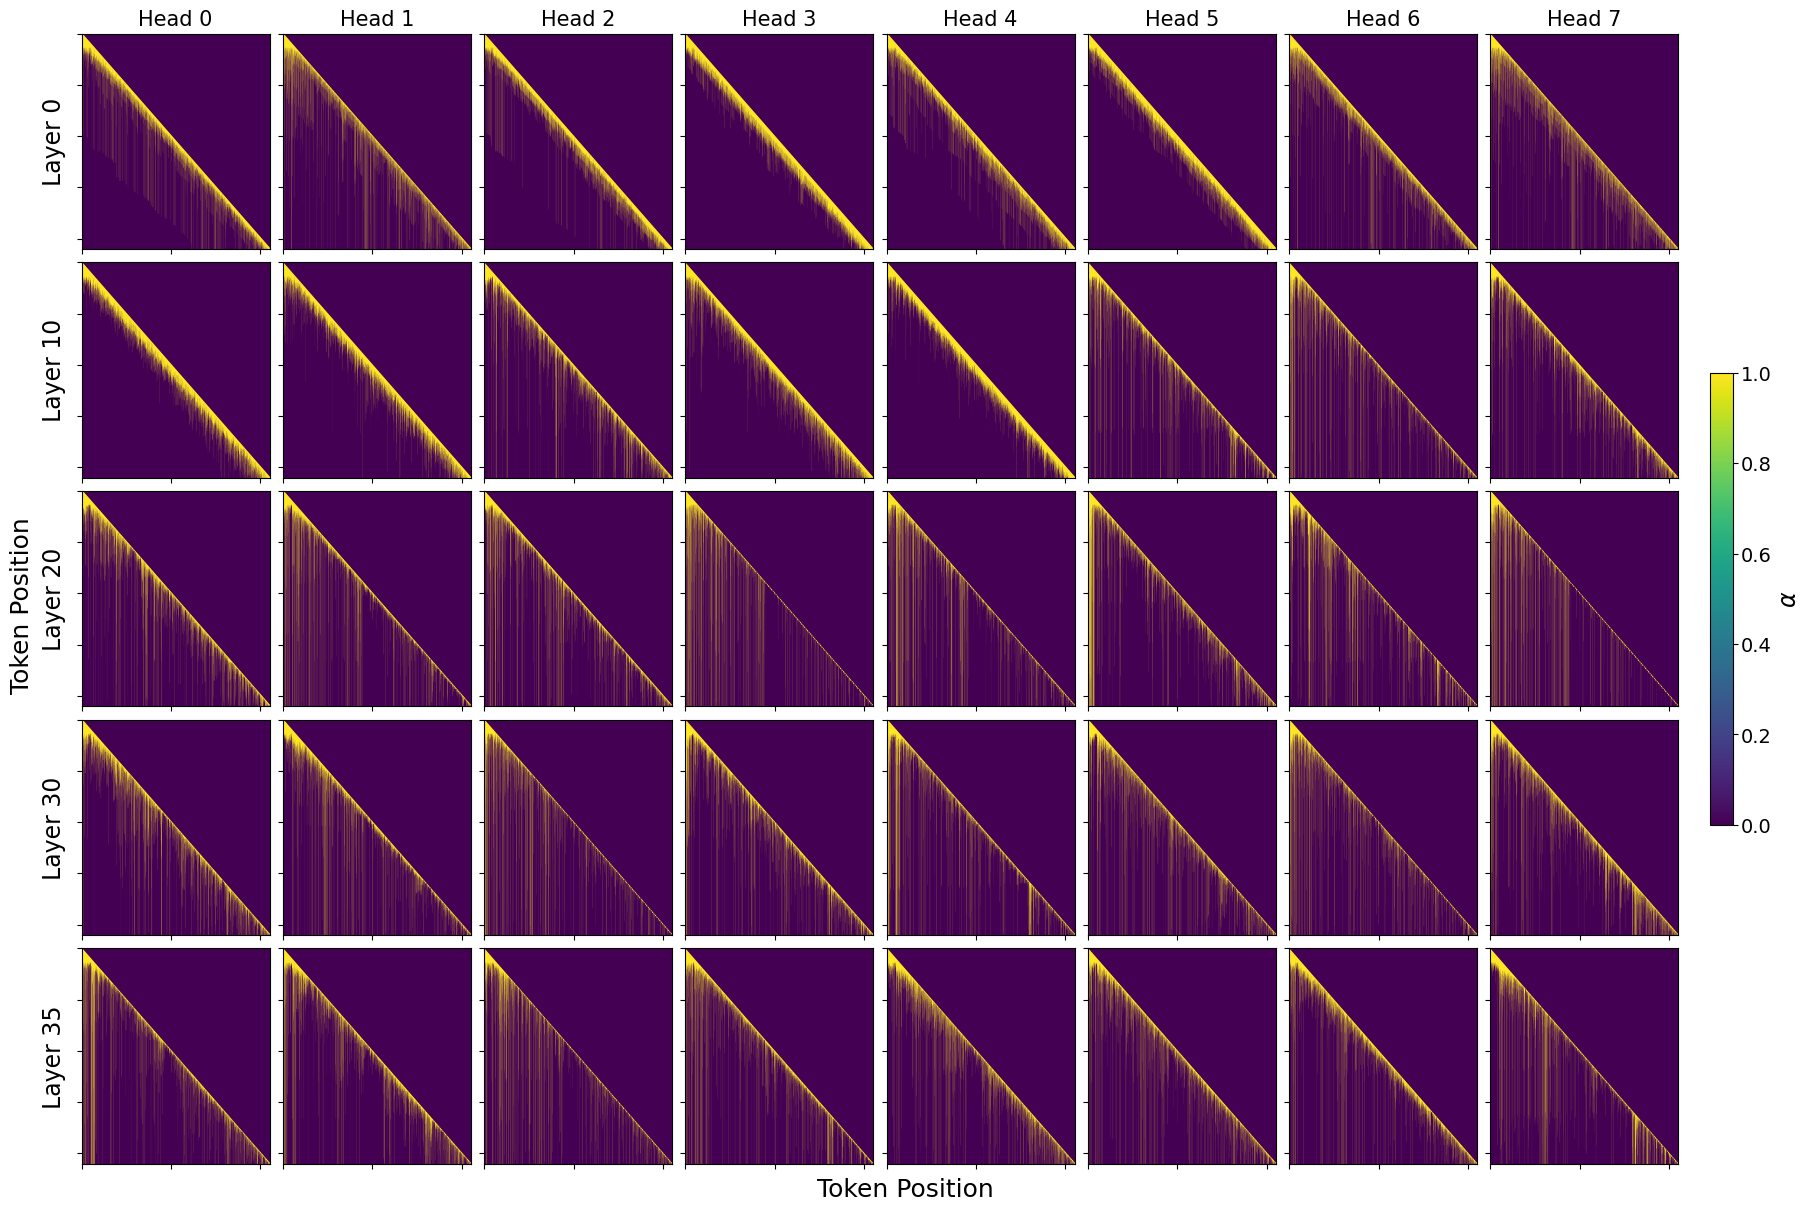

In [7]:
import matplotlib.pyplot as plt
num_layers = model.config.num_hidden_layers
num_kv_heads = model.config.num_key_value_heads

layers_to_plot = [0, 10, 20, 30, 35]
heads_to_plot = [0, 1, 2, 3, 4, 5, 6, 7]


plt.rcParams.update({
    "font.size": 15,        # base size
    "axes.titlesize": 15,   # per-axes titles ("Head …")
    "axes.labelsize": 17,   # axes labels
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

fig, axs = plt.subplots(len(layers_to_plot),
                        len(heads_to_plot),
                        figsize=(18, 12),
                        sharex=True,          # every col uses the same x ticks
                        sharey=True,          # every row uses the same y ticks
                        constrained_layout=True)

seq_len = pkv.get_seq_length() + 1

for i, layer_idx in enumerate(layers_to_plot):
    for j, head_idx in enumerate(heads_to_plot):
        ax = axs[i, j]

        evic_mat = get_eviction_matrix(logs, layer_idx, head_idx, seq_len)
        evic_mat = evic_mat.cpu().float().numpy()

        im = ax.imshow(evic_mat, vmin=0., vmax=1.,
                       cmap='viridis', aspect='auto')

        if i == 0:                 
            ax.set_title(f"Head {head_idx}")
        else:
            ax.set_title("")       

        if j == 0:                 
            ax.set_ylabel(f"Layer {layer_idx}")
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

        if i < len(layers_to_plot) - 1:
            ax.set_xticklabels([])

fig.supxlabel("Token Position")
fig.supylabel("Token Position")

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.4, fraction=0.02, pad=0.02)

cbar.ax.tick_params(labelsize=14, pad=2)
cbar.set_label(r"$\alpha$", fontsize=17)
plt.savefig("eviction_decisions.png", dpi=300)

plt.show()

In [8]:
raw_token_ids = text[0]["raw_token_ids"]

def get_token_weights(logs, seq_len, layer_idx=None, head_idx=None):
    if layer_idx is None:
        layer_list = range(model.config.num_hidden_layers)
    else:
        layer_list = [layer_idx]
    if head_idx is None:
        head_list = range(model.config.num_key_value_heads)
    else:
        head_list = [head_idx]
    token_weights_list = []
    for layer_idx in layer_list:
        for head_idx in head_list:
            evic_mat = get_eviction_matrix(logs, layer_idx, head_idx, seq_len)
            # token_weights = evic_mat.sum(dim=0) / torch.arange(seq_len, 0, -1, device=evic_mat.device).float()
            # token_weights = evic_mat.sum(dim=0) / torch.arange(seq_len, 0, -1, device=evic_mat.device).float()
            token_weights = evic_mat[-1, :]
            token_weights_list.append(token_weights)
    token_weights = torch.stack(token_weights_list, dim=0)  # (num_layers * num_heads, seq_len)
    token_weights = token_weights.mean(dim=0)  # average over layers and heads
    return token_weights


seq_len = len(raw_token_ids)
token_weights = get_token_weights(logs, seq_len, layer_idx=0, head_idx=0)
print(token_weights)
print(len(raw_token_ids), token_weights.shape)

tensor([0., 0., 0.,  ..., 1., 1., 1.])
4207 torch.Size([4207])


In [10]:
# pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import LETTER
from reportlab.lib.enums import TA_CENTER
import html

# ##FADD8F -> 00B34A

def weight_to_hex(w, gray_start=0.8):
    """
    Map w in [0,1] to a hex color from gray to blue.
    gray_start: gray level (0=black, 1=white). 0.55 ~ medium gray.
    """
    w = max(0.0, min(1.0, float(w)))
    g0 = int(gray_start * 255)
    r = int(g0 * (1 - w) + 50   * w)
    g = int(g0 * (1 - w) + 50   * w)
    b = int(g0 * (1 - w) + 255 * w)
    return f"#{r:02x}{g:02x}{b:02x}"


def _split_for_trim(tokens, weights, max_words):
    if max_words is None or len(tokens) <= max_words:
        return tokens, weights, [], [], False

    head_n = (max_words + 1) // 2  # ceil
    tail_n = max_words // 2        # floor
    return tokens[:head_n], weights[:head_n], tokens[-tail_n:], weights[-tail_n:], True

def build_weighted_pdf(tokens, weights, out_path="colored_paragraph.pdf",
                       decode_fn=None, max_words=None, ellipsis_text="..."):
    if len(tokens) != len(weights):
        raise ValueError(f"{len(tokens)} words vs {len(weights)} weights")

    head_toks, head_wts, tail_toks, tail_wts, did_trim = _split_for_trim(tokens, weights, max_words)

    def to_text(t):
        s = t if decode_fn is None else decode_fn(t)
        return html.escape(str(s))

    def colorize(ts, ws):
        return "".join(
            f'<font color="{weight_to_hex(w)}">{to_text(t)}</font>' if w <= 0.5 else f'<b><font color="{weight_to_hex(w)}">{to_text(t)}</font></b>' 
            for t, w in zip(ts, ws) 
        )

    story = []
    doc = SimpleDocTemplate(
        out_path, pagesize=LETTER,
        leftMargin=10, rightMargin=10, topMargin=10, bottomMargin=10
    )
    styles = getSampleStyleSheet()
    if "ColoredPara" not in styles:
        styles.add(ParagraphStyle(name="ColoredPara", fontName="Helvetica", fontSize=12, leading=16))
    if "EllipsisLine" not in styles:
        styles.add(ParagraphStyle(name="EllipsisLine", fontName="Helvetica", fontSize=12, leading=16, alignment=TA_CENTER))

    if did_trim:
        # prefix
        story.append(Paragraph(colorize(head_toks, head_wts), styles["ColoredPara"]))
        # centered ellipsis on its own line
        story.append(Paragraph(html.escape(ellipsis_text), styles["EllipsisLine"]))
        # suffix
        story.append(Paragraph(colorize(tail_toks, tail_wts), styles["ColoredPara"]))
    else:
        story.append(Paragraph(colorize(head_toks, head_wts), styles["ColoredPara"]))

    doc.build(story)
    print(f"PDF written to {out_path}")

layer_idx = 30
head_idx = 4
token_weights = get_token_weights(logs, seq_len, layer_idx=layer_idx, head_idx=head_idx)
build_weighted_pdf(raw_token_ids, token_weights, f"evict_layer{layer_idx}_head{head_idx}.pdf", decode_fn=tokenizer.decode,)

PDF written to evict_layer30_head4.pdf
